# Installation of Packages

In [1]:
# !pip install -q tensorflow_datasets
# !pip install datasets
# !pip install keras_cv
# !pip install keras_hub
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


# Download Dataset from external source

# Importing packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import  metrics
from tensorflow.keras import losses
from tensorflow.keras import utils
from tensorflow.keras import callbacks
from tensorflow.keras import ops
from tensorflow.keras import regularizers


import torch

from transformers import ViTImageProcessor, TFViTForImageClassification
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader

# from tensorflow.keras.datasets import mnist
# import tensorflow_datasets as tfds
from datasets import load_dataset
# from keras.applications import EfficientNetB0
# import keras_cv
# import keras_hub

# Custom Functions

# Reading Data

In [ ]:
ds = load_dataset("Docty/Blood-Cells")

# Data Inspection / Visualization

In [4]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 17092
    })
})

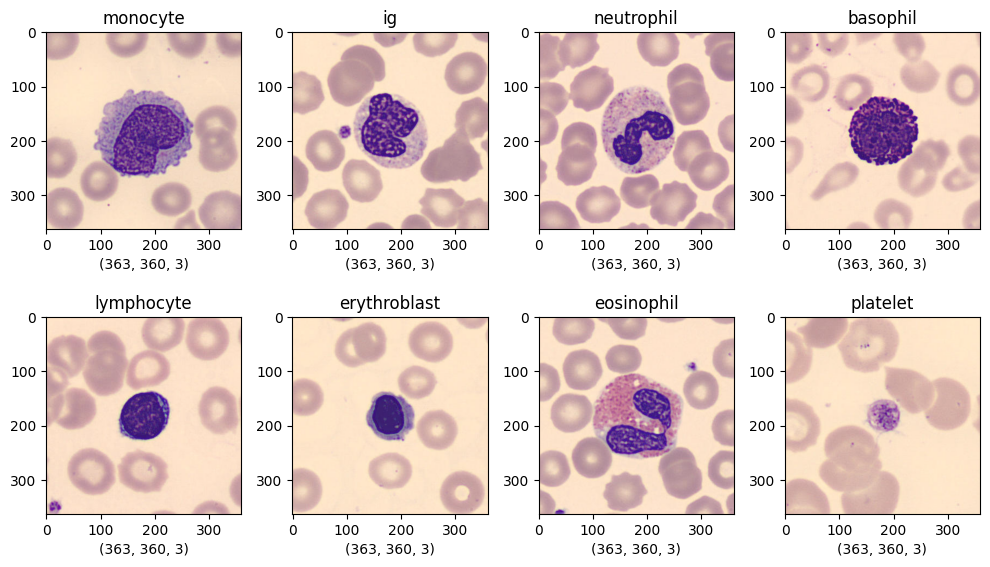

In [5]:
plt.figure(figsize=(10, 6))
for i, item in enumerate([5, 1911, 6731, 7963, 9561, 10551, 12101,   17030]):
    plt.subplot(2, 4, i+1)
    plt.imshow(ds['train'][item]['image'])
    plt.xlabel(np.array(ds['train'][item]['image']).shape)
    plt.title(ds['train'].features['label'].int2str(ds['train'][item]['label']))
    plt.tight_layout()

In [6]:
# Verifying the image size
np.array(ds['train'][0]['image']).shape, np.array(ds['train'][1950]['image']).shape, np.array(ds['train'][6731]['image']).shape

((363, 360, 3), (363, 360, 3), (363, 360, 3))

# Data Preprocessing

In [7]:
dataset = ds['train'].train_test_split(test_size=0.2)

In [8]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 13673
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 3419
    })
})

In [9]:
labels = ds['train'].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [10]:
label2id

{'monocyte': '0',
 'ig': '1',
 'neutrophil': '2',
 'basophil': '3',
 'lymphocyte': '4',
 'erythroblast': '5',
 'eosinophil': '6',
 'platelet': '7'}

In [11]:
checkpoint = 'google/vit-base-patch16-224-in21k'
imageProcessor = ViTImageProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

In [12]:
size = (imageProcessor.size["height"], imageProcessor.size["width"])

train_data_augmentation = models.Sequential(
    [
        layers.RandomCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="train_data_augmentation",
)

val_data_augmentation = models.Sequential(
    [
        layers.CenterCrop(size[0], size[1]),
        layers.Rescaling(scale=1.0 / 127.5, offset=-1),
    ],
    name="val_data_augmentation",
)

# Data Postprocessing

In [13]:
import numpy as np
import tensorflow as tf
from PIL import Image


def convert_to_tf_tensor(image: Image):
    np_image = np.array(image)
    tf_image = tf.convert_to_tensor(np_image)
    # `expand_dims()` is used to add a batch dimension since
    # the TF augmentation layers operates on batched inputs.
    return tf.expand_dims(tf_image, 0)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    images = [
        train_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    images = [
        val_data_augmentation(convert_to_tf_tensor(image.convert("RGB"))) for image in example_batch["image"]
    ]
    example_batch["pixel_values"] = [tf.transpose(tf.squeeze(image)) for image in images]
    return example_batch

In [14]:
dataset['train'].set_transform(preprocess_train)
dataset["test"].set_transform(preprocess_val)

# Model

In [15]:
from transformers import create_optimizer

batch_size = 16
num_epochs = 10
num_train_steps = len(ds) * num_epochs
learning_rate = 3e-5
weight_decay_rate = 0.01

optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=0,
)

In [ ]:
model = TFViTForImageClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id,
)

In [17]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [18]:
# converting our train dataset to tf.data.Dataset
tf_train_dataset = dataset["train"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# converting our test dataset to tf.data.Dataset
tf_eval_dataset = dataset["test"].to_tf_dataset(
    columns="pixel_values", label_cols="label", shuffle=True, batch_size=batch_size, collate_fn=data_collator
)

# Compile

In [19]:
loss =  losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss)

# Fit

In [20]:
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 6.9 MB/s eta 0:00:00


In [21]:
import evaluate

accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [22]:
from transformers.keras_callbacks import KerasMetricCallback

metric_callback = KerasMetricCallback(metric_fn=compute_metrics, eval_dataset=tf_eval_dataset)

callbacks = [metric_callback]

In [23]:
history = model.fit(tf_train_dataset, validation_data=tf_eval_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
855/855 [==============================] - 1123s 1s/step - loss: 1.9904 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 2/10
855/855 [==============================] - 1062s 1s/step - loss: 1.9894 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 3/10
855/855 [==============================] - 1076s 1s/step - loss: 1.9898 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 4/10
855/855 [==============================] - 1093s 1s/step - loss: 1.9897 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 5/10
855/855 [==============================] - 1032s 1s/step - loss: 1.9897 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 6/10
855/855 [==============================] - 1045s 1s/step - loss: 1.9901 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 7/10
855/855 [==============================] - 1059s 1s/step - loss: 1.9897 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 8/10
855/855 [==============================] - 1023s 1s/step - loss: 1.9897 - val_loss: 1.9904 - accuracy: 0.3905
Epoch 9/10
855/855 [============

# Evaluation

In [ ]:
plt.plot(history.history["accuracy"])
#plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

# Inference

In [38]:
image = ds['train'][170]["image"]

In [39]:
lab = ds['train'][170]["label"]
lab

0

In [40]:
image_processor = ViTImageProcessor.from_pretrained(checkpoint)
inputs = image_processor(image, return_tensors="tf")

In [41]:
logits = model(**inputs).logits

In [42]:
predicted_class_id = int(tf.math.argmax(logits, axis=-1)[0])

In [43]:
predicted_class_id

1

In [44]:
model.config.id2label[str(predicted_class_id)]

'ig'